## Import Packages

In [144]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import keras_tuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras import Model
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

## Defining Model Function

In [168]:
def create_1d_cnn(input_size, hls = 5):
    model = tf.keras.Sequential()
    
    filters = 32
    
    model.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape = (input_size[1], 1)))

    for i in range(hls):
        model.add(Conv1D(filters=filters, kernel_size=3, activation='relu'))
        filters *= 2
                      
        model.add(MaxPooling1D((3)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(75, activation='softmax'))
    loss = tf.keras.losses.SparseCategoricalCrossentropy() # from_logits=True
    model.compile(optimizer="adam", loss=loss)
    model.summary()
    return model

## Defining Metric function 

In [171]:
def PredictionTable(predictions, y_true):
    y_pred = []
    for pred in predictions:
        y_pred.append(np.argmax(pred))
    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred))
    new_cm = pd.DataFrame(columns = ["TN", "FP", "FN", "TP"])
    for i in range(75):
        true_negative = 0
        for j in range(75):
            if j == i:
                continue
            true_negative += sum(cm.iloc[j, 0:i]) + sum(cm.iloc[j, i+1:]) # sum(cm[j][0:i].append(cm[j][i+1:]))
        #new_cm.loc[i] = [true_negative, sum(cm[i][0:i].append(cm[i][i+1:])), sum(cm.iloc[i][0:i].append(cm.iloc[i][i+1:])), cm[i][i]]
        new_cm.loc[i] = [true_negative, sum(cm.iloc[i, 0:i])+sum(cm.iloc[i,i+1:]), sum(cm.iloc[i,0:i])+sum(cm.iloc[i, i+1:]), cm.iloc[i, i]]
    cm = new_cm
    cm["TN"] = cm["TN"].astype(np.int64)
    cm["FP"] = cm["FP"].astype(np.int64)
    cm["FN"] = cm["FN"].astype(np.int64)
    cm["TP"] = cm["TP"].astype(np.int64)
    cm = cm.assign(precision = cm["TP"] / (cm["TP"] + cm["FP"]))
    cm["precision"].astype(np.float64)
    cm = cm.assign(recall = cm["TP"] / (cm["TP"] + cm["FN"]))
    cm["recall"].astype(np.float64)
    cm = cm.assign(f1 = 2 * 1 / ((1 / cm["precision"]) + (1 / cm["recall"])))
    cm = cm.assign(fbeta = (1 + 0.5 ** 2) * (cm["precision"] * cm["recall"]) / ((0.5 ** 2 * cm["precision"]) + cm["recall"]))
    cm["fbeta"].fillna(0, inplace=True)
    cm["cluster"] = labels["Cluster"]
    cm = cm.merge(dataset_sizes, how = 'inner', left_on='cluster', right_on=0)
    cm.drop(columns=0, inplace = True)
    cm.rename(columns={2:"size"}, inplace = True)
    cm["log_size"] = np.log2(cm["size"])
    return cm

## Analysis 

### Prepping dataset for model

In [4]:
COV = 4.5

In [5]:
%%time
train = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_" + str(COV) + "_training.csv", index_col = 0)
validation = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_" + str(COV) + "_validation.csv", index_col = 0)

dataset_sizes = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/subset_sizes.csv", header = None)
#dataset_sizes.set_index(dataset_sizes.columns[0], inplace=True)
dataset_sizes.drop(dataset_sizes.index[0], inplace=True)
dataset_sizes[2] = dataset_sizes[2].astype(int)
train.head()

CPU times: user 374 ms, sys: 64.5 ms, total: 438 ms
Wall time: 451 ms


,AASS,ABCA8,ABCB1,ABCC12,ABI3BP,ACP6,ACSBG1,ACSS1,ACSS3,ACVR1C,...,VWDE,WDR49,WIF1,XAF1,YAP1,ZCCHC24,ZFHX4,ZFP36L1,ZFP36L2,Classification
F1S4_170329_150_A01,6.378897,0.000000,0.000000,0.537813,0.537813,0.000000,0.0,0.537813,0.000000,0.000000,...,6.159391,0.0,0.000000,0.0,0.537813,0.000000,0.000000,0.0,0.0,Exc L2-3 LINC00507 FREM3
F1S4_170329_152_E01,0.000000,0.517640,0.517640,0.000000,0.000000,2.627453,0.0,0.000000,0.000000,0.897800,...,0.517640,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,Inh L1 SST NMBR
F1S4_160831_075_C01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.009304,...,8.378242,0.0,0.000000,0.0,0.000000,0.591172,0.000000,0.0,0.0,Exc L2-3 LINC00507 FREM3
F1S4_170201_051_D01,0.000000,0.000000,0.000000,0.000000,0.794539,0.000000,0.0,0.000000,0.000000,6.203940,...,8.510127,0.0,0.794539,0.0,0.000000,0.000000,1.977497,0.0,0.0,Inh L3-6 VIP HS3ST3A1
F1S4_160802_076_A01,0.000000,0.612163,5.267797,0.000000,0.000000,5.054913,0.0,0.612163,0.612163,0.000000,...,7.317998,0.0,0.000000,0.0,0.612163,0.000000,0.000000,0.0,0.0,Exc L3-5 RORB ESR1


In [9]:
# Labels -> numbers
labels = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/labels.csv", index_col = 0)
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,0]] = i
train["Classification"] = train['Classification'].replace(labels_dict)
validation["Classification"] = validation['Classification'].replace(labels_dict)
train["Classification"]

F1S4_170329_150_A01     4
F1S4_170329_152_E01    28
F1S4_160831_075_C01     4
F1S4_170201_051_D01    60
F1S4_160802_076_A01     8
                       ..
F2S4_161123_024_B01    38
F1S4_170323_136_B01    18
F1S4_170321_143_C01    21
F1S4_170222_098_H01    57
F1S4_160802_052_D01     4
Name: Classification, Length: 9361, dtype: int64

In [10]:
input_size = train.shape[1] - 1
X_train = train.drop(["Classification"], axis = 1)
y_train = train["Classification"]
X_val = validation.drop(["Classification"], axis = 1)
y_val = validation["Classification"]


In [11]:
print(X_train.info())
print(y_train.info())
print(X_val.info())
print(y_val.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9361 entries, F1S4_170329_150_A01 to F1S4_160802_052_D01
Columns: 709 entries, AASS to ZFP36L2
dtypes: float64(709)
memory usage: 51.0+ MB
None
<class 'pandas.core.series.Series'>
Index: 9361 entries, F1S4_170329_150_A01 to F1S4_160802_052_D01
Series name: Classification
Non-Null Count  Dtype
--------------  -----
9361 non-null   int64
dtypes: int64(1)
memory usage: 404.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 3121 entries, F1S4_170426_100_D01 to F1S4_160831_137_E01
Columns: 709 entries, AASS to ZFP36L2
dtypes: float64(709)
memory usage: 16.9+ MB
None
<class 'pandas.core.series.Series'>
Index: 3121 entries, F1S4_170426_100_D01 to F1S4_160831_137_E01
Series name: Classification
Non-Null Count  Dtype
--------------  -----
3121 non-null   int64
dtypes: int64(1)
memory usage: 48.8+ KB
None


### Initializing the model

In [19]:
model = create_1d_cnn()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)

model

/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 707, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 705, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 233, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 23, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,035 (2.58 MB)

 Trainable params: 677,035 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_1, built=True>

### Training the model

In [20]:
history  = model.fit(X_train.to_numpy().reshape(9361, 709, 1), y_train, validation_data=(X_val.to_numpy().reshape(3121, 709, 1), y_val), epochs=50, batch_size=1024, callbacks=callback, verbose=1)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - loss: 4.1001 - val_loss: 3.8561
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 3.6444 - val_loss: 3.7493
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 3.5484 - val_loss: 3.7156
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - loss: 3.4535 - val_loss: 3.4451
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - loss: 3.3551 - val_loss: 3.2905
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 3.2326 - val_loss: 3.1390
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 3.1384 - val_loss: 2.9849
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 2.9899 - val_loss: 2.7495
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 2.8439 - val_loss: 2.5402
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 2.6892 - val_loss: 2.3745
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 2.5417 - val_loss: 2.1442
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step

### Perdiction on the validation data

In [14]:
predictions = tf.nn.softmax(model.predict(X_val.to_numpy().reshape(3121, 709, 1))).numpy()
predictions.shape

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(3121, 75)

5


(0.0, 1.5)

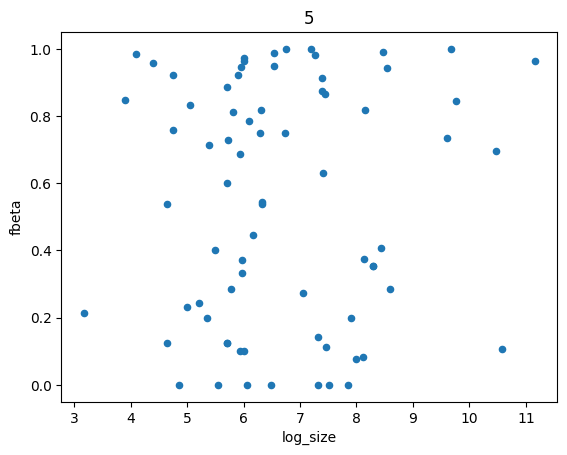

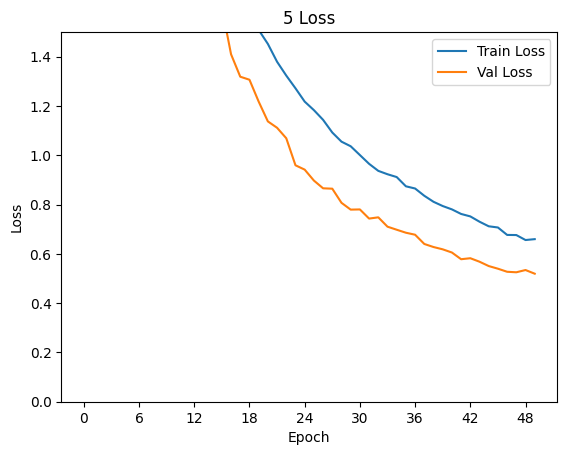

In [16]:
hidden_layers = 5
cm = PredictionTable(predictions)

fbeta_dict = {}
activation_function = "relu"
fbeta_dict[activation_function] = []
fbeta_dict[activation_function].extend(list(cm["fbeta"]))


Title = str(hidden_layers) + "Hidden Layers"

print(Title)
fig = cm.plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05], title=Title).get_figure()
# path = "Plots/" + Title + ".png"
# plt.savefig(path)
# Loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(Title + " Loss")
plt.legend(loc="best")
plt.ylim(0, 1.5)

In [17]:
cm

,TN,FP,FN,TP,precision,recall,f1,fbeta,cluster,1,size,log_size
0,3120,1,1,0,0.000000,0.000000,0.000000,0.000000,1.0,Inh L4-6 SST B3GAT2,182,7.507795
1,2928,14,14,148,0.913580,0.913580,0.913580,0.913580,2.0,Exc L5-6 RORB TTC12,167,7.383704
2,2602,26,26,431,0.943107,0.943107,0.943107,0.943107,3.0,Exc L5-6 FEZF2 ABO,373,8.543032
3,3084,22,22,12,0.352941,0.352941,0.352941,0.352941,4.0,Exc L5-6 FEZF2 EFTUD1P1,314,8.294621
4,3054,17,17,39,0.696429,0.696429,0.696429,0.696429,5.0,Exc L3-5 RORB ESR1,1428,10.479780
...,...,...,...,...,...,...,...,...,...,...,...,...
68,3099,3,3,13,0.812500,0.812500,0.812500,0.812500,69.0,Exc L5-6 SLC17A7 IL15,56,5.807355
69,3115,2,2,3,0.600000,0.600000,0.600000,0.600000,70.0,Exc L6 FEZF2 SCUBE1,52,5.700440
70,3107,1,1,12,0.923077,0.923077,0.923077,0.923077,71.0,Inh L5-6 GAD1 GLP1R,27,4.754888
71,3054,1,1,61,0.983871,0.983871,0.983871,0.983871,72.0,Inh L1-4 VIP PENK,17,4.087463


## Analysis cov threshold

Start for:  4.5
The shape of the X_train:  (9361, 709)
The shape of the X_val:  (3121, 709)


/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 707, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 705, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 233, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 23, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 5, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,035 (2.58 MB)

 Trainable params: 677,035 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

This is the model summary for  4.5
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 4.0523 - val_loss: 3.8895
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 3.6261 - val_loss: 3.8420
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 3.5331 - val_loss: 3.7263
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 3.4414 - val_loss: 3.6199
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 3.3307 - val_loss: 3.3241
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 3.1861 - val_loss: 3.2118
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 3.0741 - val_loss: 2.8965
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 2.8899 - val_loss: 2.7832
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 2.7671 - val_loss: 2.5760
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 2.5995 - val_loss: 2.3885
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 2.4358 - val_loss: 2.1387
Epoch 

/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 1424, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 1422, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 474, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 474, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 472, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 157, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 157, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 155, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 49, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 14, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 4, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,251 (4.08 MB)

 Trainable params: 1,070,251 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

This is the model summary for  3.5
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step - loss: 4.0291 - val_loss: 3.8912
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 549ms/step - loss: 3.5988 - val_loss: 3.6349
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - loss: 3.4820 - val_loss: 3.3699
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - loss: 3.3667 - val_loss: 3.2952
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - loss: 3.2477 - val_loss: 3.1684
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - loss: 3.1094 - val_loss: 3.0533
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - loss: 2.9813 - val_loss: 3.0072
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - loss: 2.8964 - val_loss: 2.9230
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - loss: 2.7742 - val_loss: 2.7631
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - loss: 2.7051 - val_loss: 2.6465
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - loss: 2.6300 - val_loss: 2.5053
Epoch 

/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)              │ (None, 3046, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 3044, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 1014, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1014, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 1012, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 337, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 337, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 335, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 111, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 111, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 109, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 36, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 36, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 34, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 11, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 11, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 5632)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,442,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,987,755 (7.58 MB)

 Trainable params: 1,987,755 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

This is the model summary for  2.5
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 4.2331 - val_loss: 3.9899
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.7297 - val_loss: 3.8961
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.6148 - val_loss: 3.8185
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.5386 - val_loss: 3.5788
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.4468 - val_loss: 3.3704
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.3844 - val_loss: 3.3844
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.3281 - val_loss: 3.2979
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.2502 - val_loss: 3.2718
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.1195 - val_loss: 3.2607
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 3.0228 - val_loss: 3.1704
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 2.9276 - val_loss: 3.0958
Epoch 12/100
10/10 ━━━━━━━━━

/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)              │ (None, 6061, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 6059, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 2019, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 2019, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 2017, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 672, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 672, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 670, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 223, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 223, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 221, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 73, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 73, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 71, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 23, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 23, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     3,014,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,560,619 (13.58 MB)

 Trainable params: 3,560,619 (13.58 MB)

 Non-trainable params: 0 (0.00 B)

This is the model summary for  1.5
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 5.4470 - val_loss: 4.2746
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 4.0478 - val_loss: 4.0162
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 3.7641 - val_loss: 3.9039
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 3.6656 - val_loss: 3.8085
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.5900 - val_loss: 3.7012
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.5127 - val_loss: 3.3913
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.4864 - val_loss: 3.4483
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.3829 - val_loss: 3.3838
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.2891 - val_loss: 3.3260
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.2744 - val_loss: 3.3054
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.2164 - val_loss: 3.2518
Epoch 12/100
10/10 ━━━━━━━━━

/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 11187, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 11185, 32)      │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 3728, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 3728, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 3726, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 1242, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 1242, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 1240, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 413, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 413, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 411, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 137, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 137, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 135, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 45, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 45, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     5,898,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,444,203 (24.58 MB)

 Trainable params: 6,444,203 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

This is the model summary for  0.52
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - loss: 6.0656 - val_loss: 4.2534
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 3.9562 - val_loss: 4.0460
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 3.7394 - val_loss: 3.8736
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 3.6525 - val_loss: 3.8166
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 3.5570 - val_loss: 3.7813
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 3.5165 - val_loss: 3.5071
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 3.4647 - val_loss: 3.3855
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 3.3848 - val_loss: 3.4236
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - loss: 3.3011 - val_loss: 3.3521
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - loss: 3.2603 - val_loss: 3.2926
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 3.1818 - val_loss: 3.2544
Epoch 12/100
10/10 ━━━━━━━━

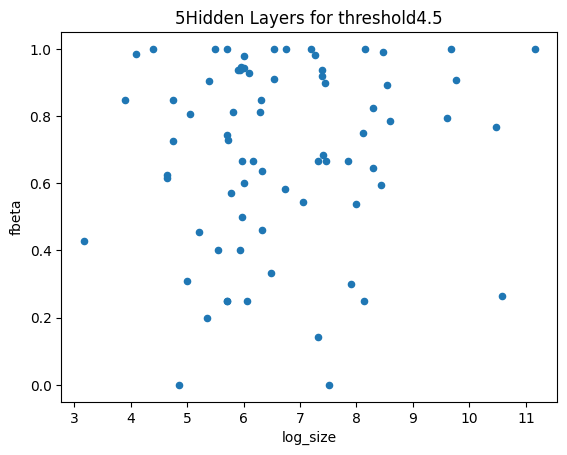

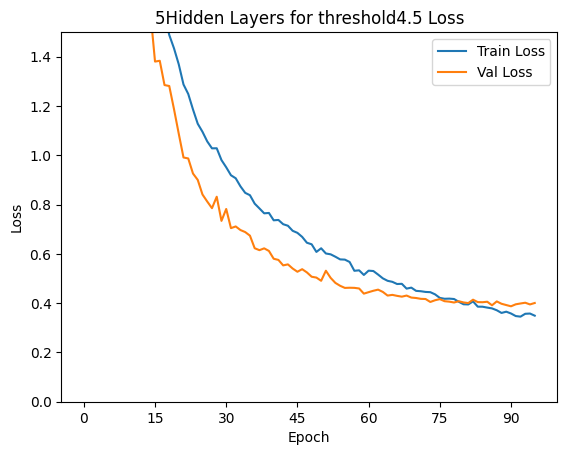

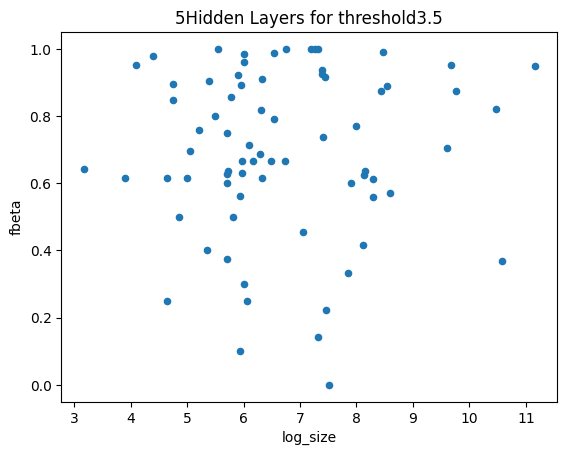

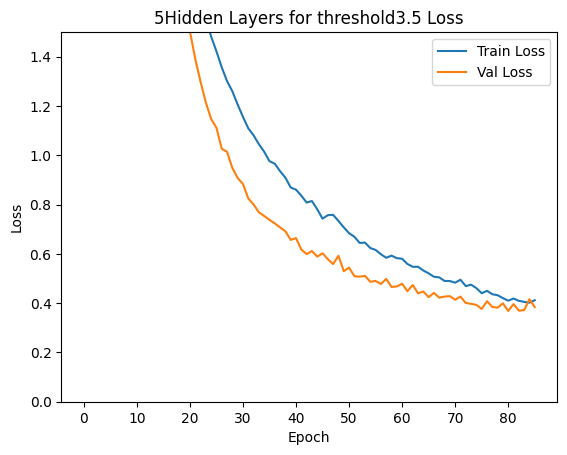

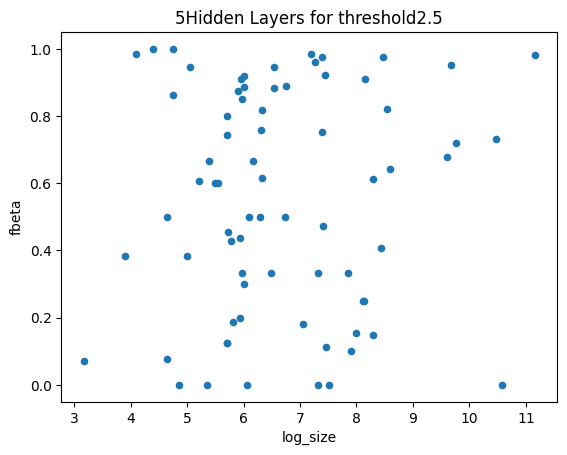

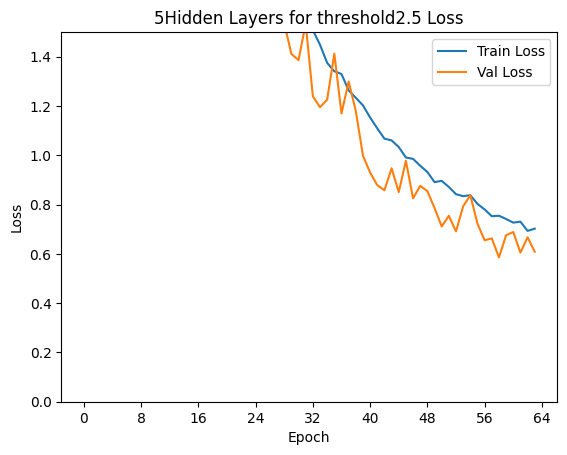

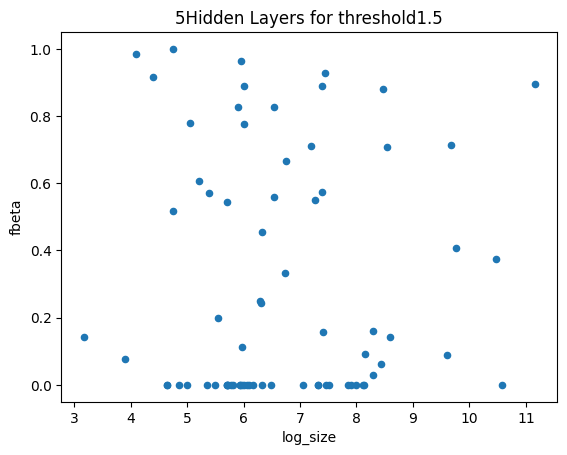

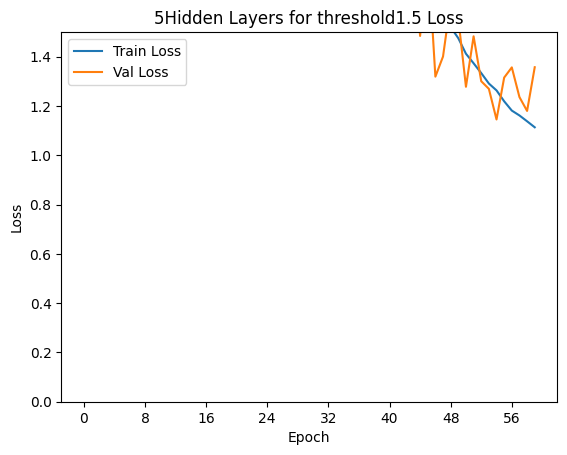

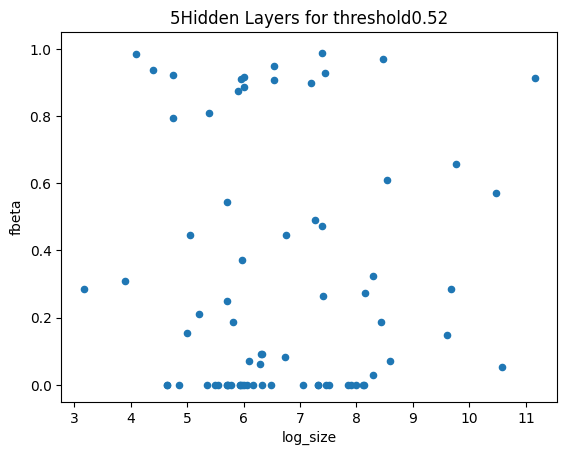

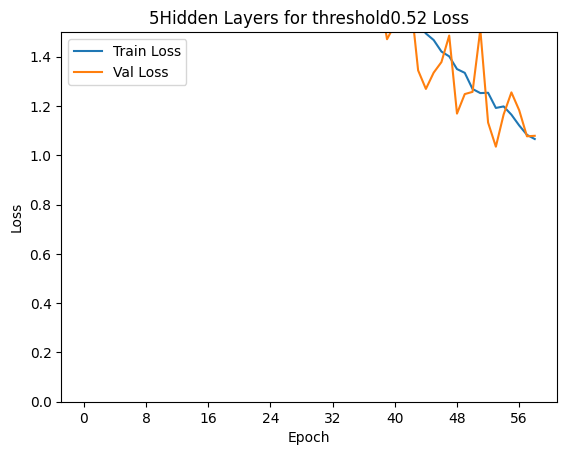

In [28]:
cm_dict = {}
# get pre-determined numerical representation of each cluster/celltype  
labels = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/labels.csv", index_col = 0)
labels.columns = ["Label", "Cluster"]
labels_dict = {}
for i in range(75):
    labels_dict[labels.iloc[i,0]] = i

# get the dataset size
dataset_sizes = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/subset_sizes.csv", header = None)
dataset_sizes.drop(dataset_sizes.index[0], inplace=True)
dataset_sizes[2] = dataset_sizes[2].astype(int)

cov_threshold = [4.5, 3.5, 2.5, 1.5, 0.52]

for t in cov_threshold:
    print("Start for: ", str(t))
    # import the train and val dataset
    
    train = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_" + str(t) + "_training.csv", index_col = 0)
    validation = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_" + str(t) + "_validation.csv", index_col = 0)

    train["Classification"] = train['Classification'].replace(labels_dict)
    validation["Classification"] = validation['Classification'].replace(labels_dict)

    X_train = train.drop(["Classification"], axis = 1)
    y_train = train["Classification"]
    X_val = validation.drop(["Classification"], axis = 1)
    y_val = validation["Classification"]

    print("The shape of the X_train: ", X_train.shape)
    print("The shape of the X_val: ", X_val.shape)
    
    # initialize the model 
    model = create_1d_cnn(input_size = X_train.shape)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
    print("This is the model summary for ", str(t))

    # log the loss for each iteration
    history  = model.fit(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1), y_train, validation_data=(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1), y_val), epochs=100, batch_size=1024, callbacks=callback, verbose=1)

    # predict on the X_val
    predictions = tf.nn.softmax(model.predict(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1))).numpy()

    hidden_layers = 5
    cm = PredictionTable(predictions)

    # save the cm 
    cm_dict[t] = cm
    
    fbeta_dict = {}
    activation_function = "relu"
    fbeta_dict[activation_function] = []
    fbeta_dict[activation_function].extend(list(cm["fbeta"]))
    
    
    Title = str(hidden_layers) + "Hidden Layers for threshold" + str(t)
    
    print(Title)
    fig = cm.plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05], title=Title).get_figure()
    # path = "Plots/" + Title + ".png"
    # plt.savefig(path)
    # Loss
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(Title + " Loss")
    plt.legend(loc="best")
    plt.ylim(0, 1.5)
    


### Plotting

5 Hidden Layers for Threshold 0.52


(0.0, 5.0)

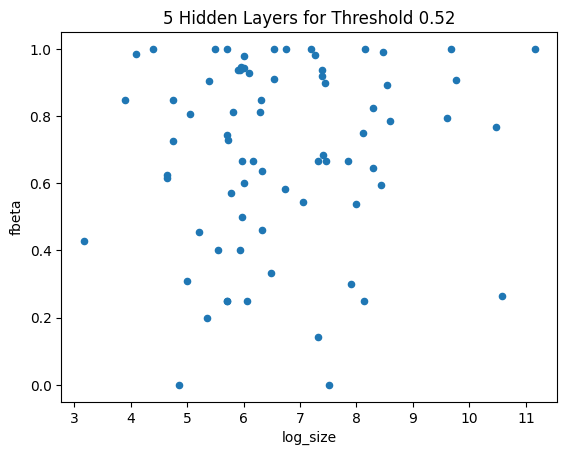

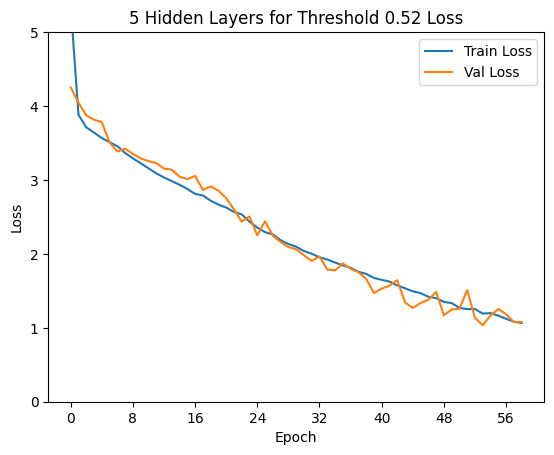

In [32]:
fbeta_dict = {}
activation_function = "relu"
fbeta_dict[activation_function] = []
fbeta_dict[activation_function].extend(list(cm["fbeta"]))
    
    
Title = str(hidden_layers) + " Hidden Layers for Threshold " + str(t)
    
print(Title)
fig = cm_dict[4.5].plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05], title=Title).get_figure()
    # path = "Plots/" + Title + ".png"
    # plt.savefig(path)
    # Loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(Title + " Loss")
plt.legend(loc="best")
plt.ylim(0, 5)

/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/seaborn/categorical.py:3398: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/seaborn/categorical.py:3398: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


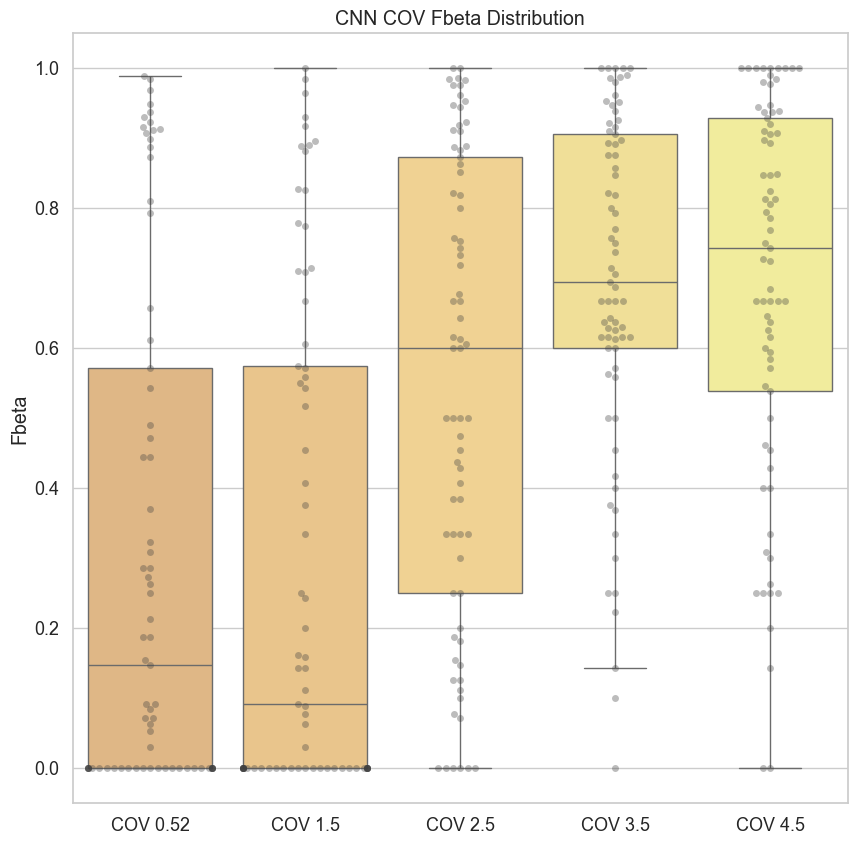

In [45]:
import seaborn as sns
covs = pd.DataFrame({"COV 0.52": cm_dict[0.52]["fbeta"], 
                     "COV 1.5": cm_dict[1.5]["fbeta"], 
                     "COV 2.5": cm_dict[2.5]["fbeta"], 
                     "COV 3.5": cm_dict[3.5]["fbeta"],
                     "COV 4.5": cm_dict[4.5]["fbeta"]})

nn_palette = ["#Eeb877", "#F8c87d", "#Ffd883", "#Ffe889", "#Fff88f"]
sns.set(style = "whitegrid", font_scale=1.18)
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data = covs, showfliers=False, palette = nn_palette).set_title('CNN COV Fbeta Distribution')
sns.swarmplot(ax = ax, data = covs, size = 5, color = ".25", alpha = 0.35)
ax.set(ylabel='Fbeta')
plt.savefig('/Users/emilyflaschner/Downloads/lili424project/results/cnn_cov_fbeta_distribution.png')
sns_dict = sns.axes_style()

In [70]:
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
# Assuming `data` is your DataFrame and `COV` is the column with COV groups
# and `F_beta` is the column with the F-beta scores.

# Perform the Kruskal-Wallis Test (non-parametric ANOVA)
stat, p = kruskal(covs["COV 0.52"], 
                  covs["COV 1.5"],
                 covs["COV 2.5"],
                 covs["COV 3.5"],
                 covs["COV 4.5"],)


# If p is significant, we proceed with post-hoc tests
if p < 0.05:
    print("Significant differences found. Proceeding with post-hoc tests.")

    for pair in itertools.combinations(["COV 0.52", "COV 1.5", "COV 2.5", "COV 3.5", "COV 4.5"], 2):
        u_statistic, p_value = mannwhitneyu(covs[pair[0]], covs[pair[1]], alternative='greater')
        print(pair[0], " > ", pair[1], " has a t-stats and p-value of: ", u_statistic, p_value)
        u_statistic, p_value = mannwhitneyu(covs[pair[0]], covs[pair[1]], alternative='less')
        print(pair[0], " < ", pair[1], " has a t-stats and p-value of: ", u_statistic, p_value)
    
    
    
else:
    print("No significant differences found.")

Significant differences found. Proceeding with post-hoc tests.
COV 0.52  >  COV 1.5  has a t-stats and p-value of:  2786.5 0.3110216448370111
COV 0.52  <  COV 1.5  has a t-stats and p-value of:  2786.5 0.6904103415427577
COV 0.52  >  COV 2.5  has a t-stats and p-value of:  1601.0 0.9999861196238455
COV 0.52  <  COV 2.5  has a t-stats and p-value of:  1601.0 1.4123388121290319e-05
COV 0.52  >  COV 3.5  has a t-stats and p-value of:  1121.5 0.9999999993410443
COV 0.52  <  COV 3.5  has a t-stats and p-value of:  1121.5 6.752606171426156e-10
COV 0.52  >  COV 4.5  has a t-stats and p-value of:  1140.5 0.9999999989748113
COV 0.52  <  COV 4.5  has a t-stats and p-value of:  1140.5 1.0502813965841186e-09
COV 1.5  >  COV 2.5  has a t-stats and p-value of:  1528.0 0.9999964399698614
COV 1.5  <  COV 2.5  has a t-stats and p-value of:  1528.0 3.626621153015135e-06
COV 1.5  >  COV 3.5  has a t-stats and p-value of:  1051.0 0.9999999998953062
COV 1.5  <  COV 3.5  has a t-stats and p-value of:  1051.

In [73]:
np.median(covs["COV 3.5"])

0.6944444444444444

In [74]:
np.median(covs["COV 4.5"])

0.7428571428571429

## Hyperparameter Optimization

### Define model function for the Random Search

In [156]:
def create_1d_cnn_tuning(hp):
    model = tf.keras.Sequential()
    
    filters = 32

    '''
    hls: This is the number of conv layers 1,2,3,4,5,6,7
    kernel_size: is either 3,5,7
    dense layers: 1,2,3
    dense unit range from 32 to 
    learning rate 
    '''
    kernel_size = hp.Choice("kernel_size", values=[3, 5, 7])
    hls = hp.Int('hls', min_value=1, max_value=5, step=1)
    padding = 'valid'
    if hls >= 5 or kernel_size >=5:
        padding = 'same'
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape = (709, 1), padding = padding)) # 709 comes from the ncol of cov 4.5

    for i in range(hls):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding = padding))
        #if filters < 1024: 
        filters *= 2
                      
        model.add(MaxPooling1D((3), padding = padding))
        model.add(Dropout(0.25))
        
    #### end of conv layers ############################
    model.add(Flatten())
    #### beginning of dense layers #####################
    nodes = 32
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(nodes,
            activation='relu'
        ))
        model.add(Dropout(0.50))
        nodes *=2

    # final layer of softmax for all 75 cell types
    model.add(Dense(75, activation='softmax'))

    
    loss = tf.keras.losses.SparseCategoricalCrossentropy() # from_logits=True

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss=loss, metrics=[f_beta] )
    
    model.summary()
    
    return model

In [157]:
def f_beta(y_true, y_pred, beta=0.5):
    # Ensure both tensors are of the same type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)  # Assuming y_pred needs rounding to get binary values

    # Calculate true positives, false positives, and false negatives
    true_positive = tf.reduce_sum(y_true * y_pred)
    false_positive = tf.reduce_sum((1 - y_true) * y_pred)
    false_negative = tf.reduce_sum(y_true * (1 - y_pred))

    # Precision, Recall, and F-beta
    precision = true_positive / (true_positive + false_positive + tf.keras.backend.epsilon())
    recall = true_positive / (true_positive + false_negative + tf.keras.backend.epsilon())
    
    fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + tf.keras.backend.epsilon())
    
    return fbeta

### Hyperparameter Optimization step Random search

In [158]:
tuner = kt.RandomSearch(
    create_1d_cnn_tuning,
    objective=kt.Objective("val_f_beta", direction="max"), 
    max_trials=30,  
    executions_per_trial=2,  
    directory='/Users/emilyflaschner/Downloads/lili424project/tuning',  
    project_name='CNN tuning', 
    #overwrite=True,
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 707, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 705, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7520)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       240,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75)             │         2,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,379 (962.42 KB)

 Trainable params: 246,379 (962.42 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
# import 
train = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_4.5_training.csv", index_col = 0)
validation = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_4.5_validation.csv", index_col = 0)

train["Classification"] = train['Classification'].replace(labels_dict)
validation["Classification"] = validation['Classification'].replace(labels_dict)

X_train = train.drop(["Classification"], axis = 1)
y_train = train["Classification"]
X_val = validation.drop(["Classification"], axis = 1)
y_val = validation["Classification"]

tuner.search(
    X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    validation_data=(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1), y_val), 
    epochs=100,
    #update_hyperparameters=update_hyperparameters,
    callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)],
)


Trial 30 Complete [00h 18m 31s]
val_f_beta: 0.027936503291130066

Best val_f_beta So Far: 0.056792741641402245
Total elapsed time: 03h 58m 39s


### Optimizing Epoches

In [163]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
optimal_model = tuner.hypermodel.build(best_hps)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
history  = optimal_model.fit(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1), y_train, validation_data=(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1), y_val), epochs=100, callbacks=callback, verbose=1)
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 709, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 709, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 237, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 237, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 237, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 79, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 79, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 79, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 27, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 9, 512)         │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 75)             │         2,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 928,363 (3.54 MB)

 Trainable params: 928,363 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - f_beta: 0.0000e+00 - loss: 4.1691 - val_f_beta: 0.0000e+00 - val_loss: 3.8838
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 1.5793e-04 - loss: 3.7489 - val_f_beta: 0.0000e+00 - val_loss: 3.4164
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 9.0083e-04 - loss: 3.4123 - val_f_beta: 0.0000e+00 - val_loss: 2.9803
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0031 - loss: 3.0817 - val_f_beta: 0.0031 - val_loss: 2.4994
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0070 - loss: 2.7734 - val_f_beta: 0.0104 - val_loss: 2.0969
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0107 - loss: 2.5546 - val_f_beta: 0.0142 - val_loss: 1.8604
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0137 - loss: 2.3126 - val_f_beta: 0.0168 - val_loss: 1.6967
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0158 - loss: 2.1708 - val_f_

### Retrain model with the epoche optimized

In [165]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
optimal_history  = optimal_model.fit(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1), y_train, validation_data=(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1), y_val), epochs=best_epoch, callbacks=callback, verbose=1)


Epoch 1/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0506 - loss: 0.4989 - val_f_beta: 0.0582 - val_loss: 0.4161
Epoch 2/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0506 - loss: 0.5116 - val_f_beta: 0.0572 - val_loss: 0.4112
Epoch 3/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0508 - loss: 0.4993 - val_f_beta: 0.0557 - val_loss: 0.4011
Epoch 4/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f_beta: 0.0507 - loss: 0.4997 - val_f_beta: 0.0566 - val_loss: 0.4038
Epoch 5/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f_beta: 0.0514 - loss: 0.4847 - val_f_beta: 0.0558 - val_loss: 0.3982
Epoch 6/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f_beta: 0.0511 - loss: 0.5001 - val_f_beta: 0.0565 - val_loss: 0.3989
Epoch 7/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f_beta: 0.0500 - loss: 0.5060 - val_f_beta: 0.0566 - val_loss: 0.3948
Epoch 8/75
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f_beta: 0.0507 - loss: 0.4845 - val_f_beta: 0.0575 - val_loss: 0.3970


## Import testing data

In [166]:
# initialize testing data
test = pd.read_csv("/Users/emilyflaschner/Downloads/lili424project/data/cov_filtered_4.5_test.csv", index_col = 0)
test["Classification"] = test['Classification'].replace(labels_dict)
X_test = test.drop(["Classification"], axis = 1)
y_test = test["Classification"]

### Classification performance between the default and optimal hyperparameter settings

In [169]:
# get the default model we had before 
default_model = create_1d_cnn(input_size = X_train.shape)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
print("This is the model summary for ", str(t))

default_history  = default_model.fit(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1), y_train, validation_data=(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1), y_val), epochs=100, batch_size=1024, callbacks=callback, verbose=1)




/Users/emilyflaschner/anaconda3/envs/iqcell_v3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 707, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 705, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 235, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 233, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 23, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 5, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,035 (2.58 MB)

 Trainable params: 677,035 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

This is the model summary for  0.52
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - loss: 3.9923 - val_loss: 3.8124
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 3.6071 - val_loss: 3.7056
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 3.5117 - val_loss: 3.6322
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 3.4177 - val_loss: 3.4213
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 3.3224 - val_loss: 3.2330
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 3.2019 - val_loss: 3.0818
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 3.0527 - val_loss: 2.8323
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 2.8647 - val_loss: 2.7939
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 2.7254 - val_loss: 2.4957
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 2.5521 - val_loss: 2.2731
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 2.4080 - val_loss: 2.0328
Epoch

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


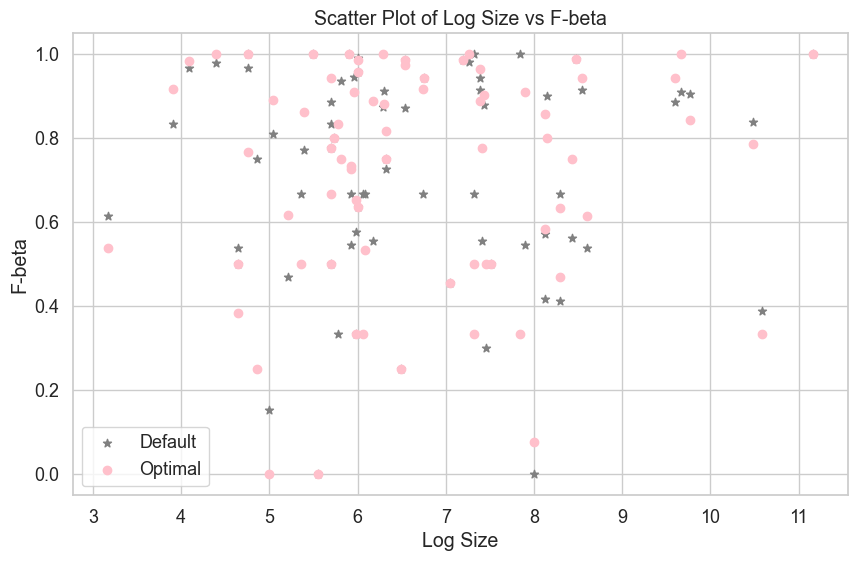

In [172]:
default_predictions = tf.nn.softmax(default_model.predict(X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1))).numpy()
default_cm = PredictionTable(default_predictions, y_true = y_test)

optimal_predictions = tf.nn.softmax(optimal_model.predict(X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1))).numpy()
optimal_cm = PredictionTable(optimal_predictions, y_true = y_test)

plt.figure(figsize=(10, 6)) 
plt.scatter(default_cm['log_size'], default_cm['fbeta'], color='grey', label='Default', marker = '*') 
plt.scatter(optimal_cm['log_size'], optimal_cm['fbeta'], color='pink', label='Optimal', marker = 'o')  
plt.ylim(-0.05, 1.05)

# Adding labels and title
plt.xlabel('Log Size')
plt.ylabel('F-beta')
plt.title('Scatter Plot of Log Size vs F-beta')
plt.legend()
plt.show()


### Model performance on training, validation, and test

293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


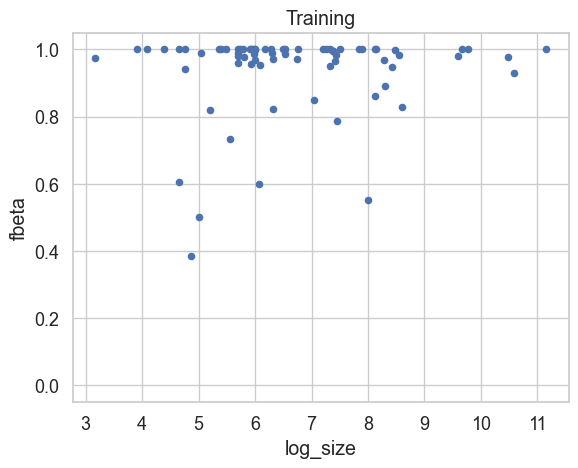

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


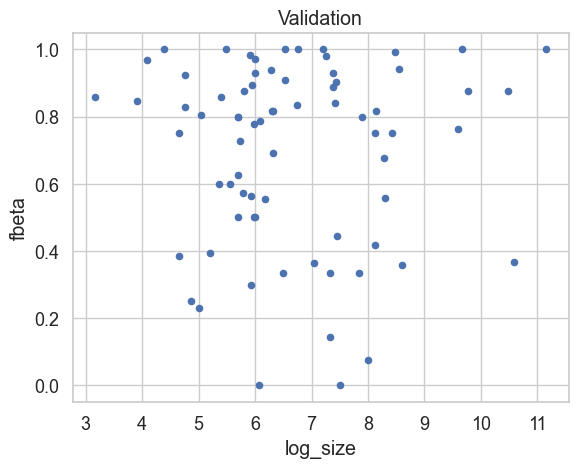

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


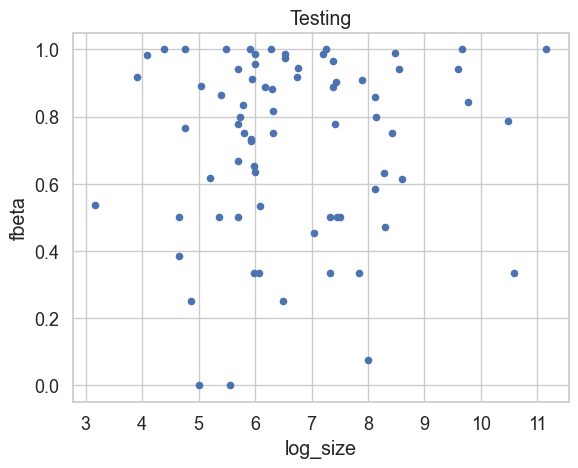

"\nfig, axs = plt.subplots(1, 3, figsize=(15, 5))\nfig.suptitle('CNN', fontsize=16)\n# Plot each image\naxs[0].imshow(image1)\naxs[0].axis('off')  # Disable axis for cleaner look\naxs[0].set_title('Training')\n\naxs[1].imshow(image2)\naxs[1].axis('off')\naxs[1].set_title('Validation')\n\naxs[2].imshow(image3)\naxs[2].axis('off')\naxs[2].set_title('Testing')\n\nplt.tight_layout()\n\n#plt.savefig('/Users/emilyflaschner/Downloads/lili424project/results/f_beta_model_performance.png')\n"

In [209]:
# predict on the X_train
predictions_train = tf.nn.softmax(optimal_model.predict(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1))).numpy()
cm_train = PredictionTable(predictions_train, y_train)
image1 = cm_train.plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05])#.get_figure()
image1.set_title('Training')
plt.show()
# predict on the X_val
predictions_val = tf.nn.softmax(optimal_model.predict(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1))).numpy()
cm_val = PredictionTable(predictions_val, y_val)
image2 = cm_val.plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05])#.get_figure()
image2.set_title('Validation')
plt.show()
# predict on the X_test
predictions_test = tf.nn.softmax(optimal_model.predict(X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1))).numpy()
cm_test = PredictionTable(predictions_test, y_test)
image3 = cm_test.plot.scatter(x="log_size", y="fbeta",ylim=[-0.05, 1.05], )#.get_figure()
image3.set_title('Testing')
plt.show()
'''
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('CNN', fontsize=16)
# Plot each image
axs[0].imshow(image1)
axs[0].axis('off')  # Disable axis for cleaner look
axs[0].set_title('Training')

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title('Validation')

axs[2].imshow(image3)
axs[2].axis('off')
axs[2].set_title('Testing')

plt.tight_layout()

#plt.savefig('/Users/emilyflaschner/Downloads/lili424project/results/f_beta_model_performance.png')
'''


### Classification peprformance for all supervised machine learning models with optimal features and hyperparameters

/var/folders/fn/v0ltfsgd477_xzrzfvhnh9lw0000gn/T/ipykernel_20505/1349807753.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = cm_test["fbeta"], showfliers=False, palette = ["#FFB6C1"]).set_title('Test Dataset Fbeta')


<Figure size 600x1000 with 0 Axes>

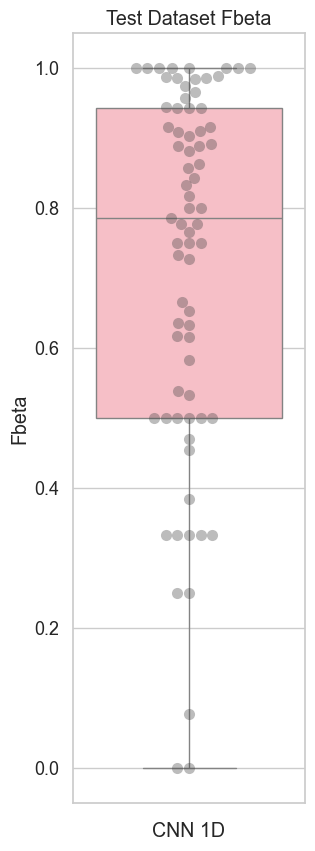

In [210]:
plt.figure(figsize=(6, 10))
sns.set(style = "whitegrid", font_scale=1.18)
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data = cm_test["fbeta"], showfliers=False, palette = ["#FFB6C1"]).set_title('Test Dataset Fbeta')
sns.swarmplot(ax = ax, data = cm_test["fbeta"], size = 8, color = ".25", alpha = 0.35)
ax.set(ylabel='Fbeta', xlabel='CNN 1D')
sns_dict = sns.axes_style()

fig.set_size_inches(3, 10)
plt.savefig('/Users/emilyflaschner/Downloads/lili424project/results/f_beta_test.png')


In [205]:
from scipy.stats import wilcoxon
predictions_optimal_train = tf.nn.softmax(optimal_model.predict(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1))).numpy()
cm_optimal_train = PredictionTable(predictions_optimal_train, y_true = y_train)

predictions_optimal_val = tf.nn.softmax(optimal_model.predict(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1))).numpy()
cm_optimal_val = PredictionTable(predictions_optimal_val, y_true = y_val)

predictions_optimal_test = tf.nn.softmax(optimal_model.predict(X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1))).numpy()
cm_optimal_test = PredictionTable(predictions_optimal_test, y_true = y_test)

predictions_default_train = tf.nn.softmax(default_model.predict(X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1))).numpy()
cm_default_train = PredictionTable(predictions_default_train, y_true = y_train)

predictions_default_val = tf.nn.softmax(default_model.predict(X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1))).numpy()
cm_default_val = PredictionTable(predictions_default_val, y_true = y_val)

print("Default Train VS Default Val: ", wilcoxon(cm_default_train["fbeta"] - cm_default_val["fbeta"]))

print("Optimal Train VS Optimal Val: ", wilcoxon(cm_optimal_train["fbeta"] - cm_optimal_val["fbeta"]))

print("Default Val VS Optimal Val: ", wilcoxon(cm_default_val["fbeta"] - cm_optimal_val["fbeta"]))

print("Optimal Val VS Optimal test: ", wilcoxon(cm_optimal_val["fbeta"] - cm_optimal_test["fbeta"]))

293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Default Train VS Default Val:  WilcoxonResult(statistic=2.0, pvalue=3.880541285720817e-13)
Optimal Train VS Optimal Val:  WilcoxonResult(statistic=0.0, pvalue=1.6396723837080768e-12)
Default Val VS Optimal Val:  WilcoxonResult(statistic=518.0, pvalue=0.2486502560081163)
Optimal Val VS Optimal test:  WilcoxonResult(statistic=757.5, pvalue=0.12467714896831475)


In [207]:
for hyperparam in best_hps.values:
    print(hyperparam, best_hps[hyperparam])

kernel_size 5
hls 5
num_dense_layers 1
learning_rate 0.00012617583880932836
